# APM Inspections PMF Analysis
#### To grow, or not to grow?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import warnings

In [2]:
ttl_properties = 1657908

### SQL Queries

[Source](https://cupola.appfolio.com/queries/11581/source): `https://cupola.appfolio.com/queries/11581/source`

SQL to get properties, units, property_type, portfolio

```sql
select 
    p.vhost
    , p.id
    , p.property_type
    , v.property_portfolio_type
    , count(u.id) as cnt_units
from property_properties p
left outer join property_unit_groups ug on p.vhost = ug.vhost and p.id = ug.property_id 
left outer join property_units u on p.vhost = u.vhost and u.unit_group_id = ug.id
left outer join vhost_property_portfolio v on p.vhost = v.vhost
group by p.vhost, p.id, p.property_type, v.property_portfolio_type
```

SQL to get move-outs by property

```SQL
select m.vhost, p.id as property_id, m.created_at::date as move_out_date
from property_move_outs m
left JOIN property_occupancies o ON m.occupancy_id = o.id AND m.vhost = o.vhost
left JOIN property_units u ON o.unit_id = u.id AND m.vhost = u.vhost
left JOIN property_unit_groups ug ON u.unit_group_id = ug.id AND m.vhost = ug.vhost
left JOIN property_properties p ON ug.property_id = p.id AND m.vhost = p.vhost
left JOIN vhost_property_portfolio v on m.vhost = v.vhost -- and v.property_portfolio_type like 'Large Res%'
where m.completed_move_out = true
    and m.created_at BETWEEN current_date()::date - interval '540 days' AND current_date()
```

SQL to get inspections by occupancy

```SQL
SELECT i.vhost, p.id as property_id, i.created_at::date as inspection_date
FROM property_inspections_inspections i
JOIN property_occupancies o ON i.inspectable_id = o.id AND i.vhost = o.vhost
JOIN property_units u ON o.unit_id = u.id AND i.vhost = u.vhost
JOIN property_unit_groups ug ON u.unit_group_id = ug.id AND i.vhost = ug.vhost
JOIN property_properties p ON ug.property_id = p.id AND i.vhost = p.vhost
JOIN vhost_property_portfolio v on i.vhost = v.vhost -- and v.property_portfolio_type like 'Large Res%'
WHERE inspectable_type = 'Occupancy'
    AND i.created_at BETWEEN current_date()::date - interval '540 days' AND current_date()
```

SQL to get inspections by unit

```SQL
SELECT i.vhost, p.id as property_id, i.created_at::date as inspection_date
FROM property_inspections_inspections i
JOIN property_units u ON i.inspectable_id = u.id AND i.vhost = u.vhost
JOIN property_unit_groups ug ON u.unit_group_id = ug.id AND i.vhost = ug.vhost
JOIN property_properties p ON ug.property_id = p.id AND i.vhost = p.vhost
JOIN vhost_property_portfolio v on i.vhost = v.vhost -- and v.property_portfolio_type like 'Large Res%'
WHERE inspectable_type = 'Unit'
    AND i.created_at BETWEEN current_date()::date - interval '540 days' AND current_date()
```

SQL to get inspections by property

```SQL
SELECT i.vhost, i.inspectable_id as property_id, i.created_at::date as inspection_date
FROM property_inspections_inspections i
JOIN vhost_property_portfolio v on i.vhost = v.vhost -- and v.property_portfolio_type like 'Large Res%'
WHERE inspectable_type = 'Property'
    AND i.created_at BETWEEN current_date()::date - interval '540 days' AND current_date()
```

In [3]:
move_out_file = '~/Downloads/4740948_2020_11_13.csv'
occupancy_file = '~/Downloads/4741030_2020_11_14.csv'
units_file = '~/Downloads/4741031_2020_11_14.csv'
property_file = '~/Downloads/4741035_2020_11_14.csv'
unit_details = '~/Downloads/4741461_2020_11_14.csv'

### Create dataframes

* Create user as `concatenate(VHOST + PROPERTY_ID)`
* Create date by transforming str date to timstamp
* Join inspection dataframes together, drop `np.nan`'s        

In [4]:
df = pd.read_csv(move_out_file)
df_o = pd.read_csv(occupancy_file)
df_u = pd.read_csv(units_file)
df_p = pd.read_csv(property_file)
frames = [df_o, df_u, df_p]
df_i = pd.concat(frames, ignore_index=True)

In [5]:
df_i['date'] = pd.to_datetime(df_i['INSPECTION_DATE'])
df_i['user'] = df_i['VHOST'] + df_i['PROPERTY_ID'].astype(str)

In [6]:
df['date'] = pd.to_datetime(df['MOVE_OUT_DATE'])
df['user'] = df['VHOST'] + df['PROPERTY_ID'].astype(str)

In [7]:
df_ud = pd.read_csv(unit_details)
df_ud['user'] = df_ud['VHOST'] + df_ud['ID'].astype(str)
df_i = df_i.set_index('user').join(df_ud.drop(['VHOST', 'ID'], axis=1).set_index('user'), rsuffix='_details').dropna(subset=['CNT_UNITS']).reset_index()

### Calculate MAU by first-active-date cohort

* Define max-min date range for analysis
* Create cohorts of unique active users, by date of first use
  * Exclude any active user in a previous cohort from a subsequent cohort (MECE)
* Evaluate which of a cohorts active users are active on each subsequent day
* Store the active rate `total active ÷ total cohort`
* Store the `total active`

In [8]:
def active_users_by_cohort(event_df, period_length):
    active_user_df = pd.DataFrame({"date": pd.date_range(event_df['date'].min(), event_df['date'].max())})
    active_user_count_df = pd.DataFrame({"date": pd.date_range(event_df['date'].min(), event_df['date'].max())})
    existing_users = set()
    for cohort_date in trange(len(active_user_df)):
        active_user_df[cohort_date] = np.nan
        active_user_count_df[cohort_date] = 0
        origin_date = active_user_df['date'][cohort_date]
        offset_date = origin_date - pd.offsets.Day(int(period_length))
        base_cohort = set(event_df[
                             (event_df['date'] <= origin_date) & 
                             (event_df['date'] > offset_date)  
                             ]['user'].unique()) - existing_users
        existing_users.update(base_cohort)
        for i in range(cohort_date, len(active_user_df)):
            origin_date = active_user_df['date'][i]
            offset_date = origin_date - pd.offsets.Day(int(period_length))
            current_cohort = set(event_df[
                             (event_df['date'] <= origin_date) & 
                             (event_df['date'] > offset_date)  
                             ]['user'].unique())
            if len(base_cohort) != 0:
                active_user_df.loc[i, cohort_date] = len(base_cohort & current_cohort)/len(base_cohort)
                active_user_count_df.loc[i, cohort_date] = len(base_cohort & current_cohort)
    return active_user_df, active_user_count_df


In [10]:
# # subset on high-density MFR (≥20 units)
df_HDMFR = df_i[
    (df_i['CNT_UNITS'] >= 20) &
    (df_i['PROPERTY_TYPE'] == 'Multi-Family')
]

# # subset high-density (≥20 units) MFR by segment (smb, mm, corp)
df_HDMFR_SMB = df_i[
    (df_i['CNT_UNITS'] >= 20) &
    (df_i['PROPERTY_PORTFOLIO_TYPE'] == 'SMB Res') &
    (df_i['PROPERTY_TYPE'] == 'Multi-Family')
]

df_HDMFR_MM = df_i[
    (df_i['CNT_UNITS'] >= 20) &
    (df_i['PROPERTY_PORTFOLIO_TYPE'] == 'Large Res Mid-Market') &
    (df_i['PROPERTY_TYPE'] == 'Multi-Family')
]

df_HDMFR_C = df_i[
    (df_i['CNT_UNITS'] >= 20) &
    (df_i['PROPERTY_PORTFOLIO_TYPE'] == 'Large Res Corporate') &
    (df_i['PROPERTY_TYPE'] == 'Multi-Family')
]

[df_HDMFR.shape, df_HDMFR_SMB.shape, df_HDMFR_MM.shape, df_HDMFR_C.shape]

[(277849, 8), (92272, 8), (102208, 8), (37146, 8)]

In [11]:
df_HDMFR_SMB_user_rate, df_HDMFR_SMB_user_count = active_users_by_cohort(df_HDMFR_SMB, 31)

In [12]:
df_HDMFR_MM_user_rate, df_HDMFR_MM_user_count = active_users_by_cohort(df_HDMFR_MM, 31)

In [13]:
df_HDMFR_C_user_rate, df_HDMFR_C_user_count  = active_users_by_cohort(df_HDMFR_C, 31)

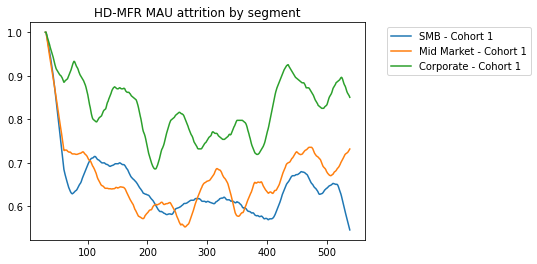

In [32]:
sample_cohort = 1

fig, ax = plt.subplots()
ax.set_title('HD-MFR MAU attrition by segment')
# p1, = ax.plot(df_HDMFR_users['date'], df_HDMFR_users[df_HDMFR_users.columns[1]].rolling(30).mean(), label='All')
p2, = ax.plot(df_HDMFR_SMB_user_rate.index, df_HDMFR_SMB_user_rate[df_HDMFR_SMB_user_rate.columns[sample_cohort]].rolling(30).mean(), label='SMB - Cohort {}'.format(sample_cohort))
p3, = ax.plot(df_HDMFR_MM_user_rate.index, df_HDMFR_MM_user_rate[df_HDMFR_MM_user_rate.columns[sample_cohort]].rolling(30).mean(), label='Mid Market - Cohort {}'.format(sample_cohort))
p4, = ax.plot(df_HDMFR_C_user_rate.index, df_HDMFR_C_user_rate[df_HDMFR_C_user_rate.columns[sample_cohort]].rolling(30).mean(), label='Corporate - Cohort {}'.format(sample_cohort))

# ax2 = ax.twinx()
# p5, = ax2.plot(df_HDMFR_SMB_user_count['date'], np.diag(df_HDMFR_SMB_user_count.iloc[:, df_HDMFR_SMB_user_count.columns != 'date']).cumsum(), label='SMB Unique Actives CUMSUM')
# p6, = ax2.plot(df_HDMFR_MM_user_rate['date'], np.diag(df_HDMFR_MM_user_count.iloc[:, df_HDMFR_MM_user_count.columns != 'date']).cumsum(), label='MM Unique Actives CUMSUM')
# p7, = ax2.plot(df_HDMFR_C_user_rate['date'], np.diag(df_HDMFR_C_user_count.iloc[:, df_HDMFR_C_user_count.columns != 'date']).cumsum(), label='C Unique Actives CUMSUM')

# fig.autofmt_xdate()
# plt.legend(handles=[p2, p3, p4, p5, p6, p7], bbox_to_anchor=(1.15, 1), loc='upper left')
plt.legend(handles=[p2, p3, p4], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [147]:
def cohort_mean(df_counts, df_rates):
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='invalid value encountered in true_divide')
        cohort_mean = dict()
        usage_rate_by_day = {i*-1: np.diag(df_rates.iloc[:, df_rates.columns != 'date'], i).astype('float64') for i in range(-1*(df_rates.shape[0]-1), 1)}
        users_by_cohort_day = {i*-1: np.diag(df_counts.iloc[:, df_counts.columns != 'date'], i).astype('float64') for i in range(-1*(df_counts.shape[0]-1), 1)}
        for key, val in users_by_cohort_day.items():
            cohort_mean[key] = users_by_cohort_day[key].sum() / np.nansum(users_by_cohort_day[key] / usage_rate_by_day[key])
    return cohort_mean

In [150]:
user_counts = {'corp': [df_HDMFR_C_user_count, df_HDMFR_C_user_rate], 'mid-market': [df_HDMFR_MM_user_count, df_HDMFR_MM_user_rate], 'smb': [df_HDMFR_SMB_user_count, df_HDMFR_SMB_user_rate]}
max_dim = max([v[0].shape[0] for v in user_counts.values()])

df = pd.DataFrame(index=range(max_dim))
for cohort, data in user_counts.items():
    df[cohort] = np.nan
    computed_mean = cohort_mean(data[0], data[1])
    for key, val in computed_mean.items():
        df.loc[key, cohort] = val

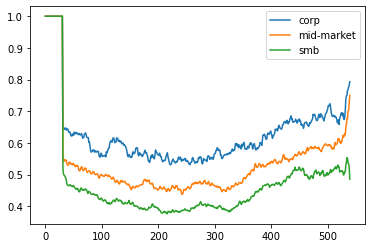

In [151]:
df.plot()

In [120]:
# This is legacy, superceded by active_users_by_cohort
"""
def active_users_in_period(event_df, col_name, period):
    active_user_df = pd.DataFrame({"date": pd.date_range(event_df['date'].min(), event_df['date'].max())})
    active_user_df[col_name] = 0   # Creates the empty column to be filled
    for i in range(len(active_user_df)):
        origin_date = active_user_df['date'][i]
        offset_date = origin_date - pd.offsets.Day(int(period))
        # filter the original dataframe and count unique visitors
        count = len(event_df.loc[
                                (event_df['date'] <= origin_date) & 
                                (event_df['date'] > offset_date),
                                'user'].unique())
        active_user_df.loc[i, col_name] = count
    return active_user_df
"""

# When running into runtime warnings re: np.nanmean can get rid of errors this way
"""
# Expect runtime warnings for taking mean of arrays containing all nan
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', message='invalid value encountered in true_divide')
    diagonal_dict = {i*-1: np.nanmean(np.diag(df.iloc[:, df.columns != 'date'], i).astype('float64')) for i in range(-1*(df.shape[0]), 0)}
    diagonal_df = pd.DataFrame.from_dict(diagonal_dict).reset_index()
"""